# Regression

Based on feedback from our TF on 12/7, we attempted several forms of regression to see how well we could predict numerical graduation rate with school district characteristics alone, then with previous years graduation rates, then with school district characteristics and previous years graduation rates.

One opportunity in this space is that the U.S. Department of Education typically delays making graduation rate data available.  For instance, it is the 2015-2016 school year, and the most current graduation rate data available is for the year 2009-2010.  If we could build a model to predict graduation rate for the years of missing data, organizations that rely on graduation rate data to provide schools services could use this graduation rate approximation until newer graduation rate data becomes available.

For this notebook, we pulled 3 previous years of graduation rate data (2006-2007, 2007-2008, and 2008-2009).  First we built regression models using school district data alone and predicting numerical graduation rate, then we built regression models using historic graduation rate data alone and predicting numerical graduation rate, then we built regression models using school district data and historic graduation rate data and predicting numerical graduation rate, and lastly we built a regression model using 2006-2007 school district data and fed it new 2009-2010 school district data to see how well it would predict 2009-2010 numerical graduation rate.

We compared the models using mean squared error, with the lower the mean squared error, the better.

#Table of Contents
* [1. Linear Regression](#Linear-Regression)<br>
* [2. Lasso Regression](#Lasso-Regression)<br>
* [3. Elastic Net Regression](#Elastic-Net-Regression)<br>
* [4. Predicting graduation based on previous year graduation](#Predicting-graduation-based-on-previous-year-graduation)<br>
    * [1. Linear Regression - 0607, 0708, and 0809](#Linear-Regression---0607,-0708,-and-0809)<br>
    * [2. Linear Regression - 0708 and 0809](#Linear-Regression---0708-and-0809)<br>
    * [3. Linear Regression - 0809 Only](#Linear-Regression---0809-Only)<br>
    * [4. Linear Regression - 0708 Only](#Linear-Regression---0708-Only)<br>
    * [5. Linear Regression - 0607 Only](#Linear-Regression---0607-Only)<br>
* [5. Predicting graduation based on previous year graduation and all other factors](#Predicting-graduation-based-on-previous-year-graduation-and-all-other-factors)<br>
    * [1. Linear Regression](#Linear-Regression)<br>
    * [2. Lasso Regression](#Lasso-Regression)<br>
    * [3. Elastic Net Regression](#Elastic-Net-Regression)<br>
    * [4. Creating a best model](#Creating-a-best-model)<br>
    * [5. Findings](#Findings)<br>
* [6. Trying 2009-2010 predictions using 2006-2007 data](#Trying-2009-2010-predictions-using-2006-2007-data)<br>
    * [1. Linear Regression](#Linear-Regression)<br>
    * [2. Lasso Regression](#Lasso-Regression)<br>
    * [3. Elastic Net](#Elastic-Net)<br>
    * [4. Creating a best model](#Creating-a-best-model)<br>
    * [5. Predicting 2009-2010 graduation rate from 2006-2007 data.](#Predicting-2009-2010-graduation-rate-from-2006-2007-data.)<br>


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
fullprevyears = pd.read_csv("data/finaldata/dftouse_withprevyears.csv")

In [3]:
dftouse = fullprevyears.copy(deep=True)

In [4]:
dftouse.shape

(10785, 160)

In [5]:
dftouse.head()

,num_schools,num_charter_schools,num_pub_schools,num_students,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,tlocrev_percent,tsrev_percent,afgr,i_agency_type_local_school_district,i_agency_type_local_school_district_sup_union,i_agency_type_regional_education_services,i_agency_type_charter_school_agency,i_fin_sdlc_sec,i_fin_sdlc_elem_sec,i_fin_sdlc_voc,i_ucl_city_large,i_ucl_city_mid,i_ucl_city_small,i_ucl_suburb_large,i_ucl_suburb_mid,i_ucl_suburb_small,i_ucl_town_fringe,i_ucl_town_distant,i_ucl_town_remote,i_ucl_rural_fringe,i_ucl_rural_distant,i_ucl_rural_remote,i_cs_all_charter,i_cs_charter_noncharter,...,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,gradrate0607,gradrate0708,gradrate0809
0,1,1,1,360,15.65,17.14,11111,356,7925,2831,3986,4717,436,4133,1028,11197,1986,72,9139,3986,11.2,43.6,4.8,45.2,51.6,25.5,3.2,71.3,30.2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0,0,0.070312,0.390625,0.000000,0,0.062500,0.000000,0.000000,0.000000,0,0.000000,0.078125,0.007812,0.000000,0.390625,0,0.00000,0.964599,0.000000,0.000000,0.000000,0.003155,0.000000,0,0,0.003155,0.000000,0.029092,0.000000,0.000000,0,0.606477,0.000000,0.156035,0.000000,0.000000,0.000000,0.176644,0.060844,0,0,0,0.000000,0,1,NaN,NaN,NaN
1,1,1,1,594,28.49,28.49,10557,10285,273,0,5104,3003,0,4199,1456,8732,554,0,8108,5104,18.0,63.0,0.0,51.8,37.0,0.0,97.4,2.6,100.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0.000000,0,0,0.000000,0.983958,0.005893,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.010149,0.000000,0.000000,0.000000,0,0.00000,0.000000,0.000000,0.000000,0.950617,0.000000,0.000000,0,0,0.000000,0.000000,0.049383,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000,1,0,100.0,100.0,100.0
2,1,1,1,1033,16.61,16.61,11015,68,9164,1784,4890,3500,441,5788,477,8864,0,1,8832,4890,5.4,55.4,5.0,65.5,39.6,16.2,0.6,83.2,55.7,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0,0,0.000000,0.000000,0.000000,0,0.800000,0.000000,0.000000,0.000000,0,0.142857,0.000000,0.000000,0.057143,0.000000,0,0.00000,0.952145,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000211,0.006233,0.040038,0.001373,0,0.351058,0.056430,0.238741,0.033641,0.000000,0.000000,0.320130,0.000000,0,0,0,0.000000,0,1,75.6,41.4,NaN
3,3,0,3,432,11.86,12.08,11367,4374,5089,1904,4835,4633,498,5741,2112,13200,2204,0,9966,4835,21.2,48.5,5.0,57.6,46.5,16.7,38.5,44.8,70.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0.000000,0,0,0.000000,0.001049,0.000000,0,0.060829,0.009963,0.014683,0.000000,0,0.005244,0.052438,0.027792,0.004195,0.000000,0,0.02517,0.642181,0.049572,0.068049,0.000000,0.004056,0.000901,0,0,0.000000,0.000901,0.015773,0.218567,0.000000,0,0.162651,0.306024,0.087952,0.038554,0.002410,0.000000,0.402410,0.000000,0,0,0,0.000000,0,1,97.1,81.6,83.3
4,2,0,2,595,15.64,13.37,10718,5634,4020,1065,4944,2103,336,4703,1438,11586,2769,0,7384,4944,19.5,67.0,4.6,63.7,28.5,9.9,52.6,37.5,95.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0.061464,0,0,0.000000,0.043101,0.000000,0,0.034175,0.008926,0.004336,0.002805,0,0.004081,0.066820,0.000000,0.000000,0.004081,0,0.00000,0.859543,0.000000,0.000000,0.118656,0.000000,0.002144,0,0,0.000000,0.001072,0.018585,0.000000,0.000000,0,0.095816,0.107962,0.1

In [6]:
STANDARDIZABLE = ['num_students', 'num_schools','num_charter_schools','num_pub_schools','tcuresal_percent','pupil_teacher_ratio_dist', 'pupil_teacher_ratio_ps', 'totalrev_pp','tlocrev_pp','tsrev_pp','tfedrev_pp','tcurinst_pp','tcurssv_pp','tcuroth_pp','tcursalary_pp','tcurbenefits_pp','totalexp_pp','tcapout_pp','tnonelse_pp','tcurelsc_pp','instexp_pp','tcurinst_percent','tcuroth_percent','tcurelsc_percent','tcurssvc_percent','tfedrev_percent','tlocrev_percent','tsrev_percent','r_ELL','r_IEP','r_lunch_free','r_lunch_reduced','r_stud_PKK','r_stud_18','r_stud_912','r_stud_re_M','r_stud_re_F','r_stud_re_AIAN','r_stud_re_AAP','r_stud_re_H','r_stud_re_B','r_stud_re_W','r_stud_re_HNPI','r_stud_re_Two','r_stud_re_Total','r_stud_reg_12_AIAN_M','r_stud_reg_12_AIAN_F','r_stud_reg_12_AAP_M','r_stud_reg_12_AAP_F','r_stud_reg_12_H_M','r_stud_reg_12_H_F','r_stud_reg_12_B_M','r_stud_reg_12_B_F','r_stud_reg_12_W_M','r_stud_reg_12_W_F','r_stud_reg_12_HNPI_M','r_stud_reg_12_HNPI_F','r_stud_reg_12_Two_M','r_stud_reg_12_Two_F','r_st_PKT','r_st_KT','r_st_ET','r_st_ST','r_st_UT','r_st_TS','r_st_IA','r_st_IC','r_st_EGC','r_st_SGC','r_st_OGC','r_st_TGC','r_st_LMS','r_st_LMSS','r_st_LEA','r_st_LEASS','r_st_SA','r_st_SASS','r_st_SSSS','r_st_OSSS','r_lrev_pt','r_lrev_gst','r_lrev_put','r_lrev_it','r_lrev_aot','r_lrev_pgc','r_lrev_cc','r_lrev_oss','r_lrev_tui','r_lrev_trans','r_lrev_slr','r_lrev_ts','r_lrev_sar','r_lrev_osalserv','r_lrev_sfns','r_lrev_ie','r_lrev_molr','r_lrev_sp','r_lrev_rr','r_lrev_sale','r_lrev_ff','r_lrev_pc','r_srev_gfa','r_srev_sep','r_srev_trans','r_srev_sip','r_srev_cbsp','r_srev_vep','r_srev_codsp','r_srev_bep','r_srev_gt','r_srev_slp','r_srev_aor','r_srev_splea','r_srev_osp','r_srev_ns','r_frev_title1','r_frev_dis','r_frev_cna','r_frev_ems','r_frev_dfs','r_frev_voc','r_frev_ao','r_frev_ns','r_frev_ia','r_frev_be','r_frev_na','r_frev_aofed']
print STANDARDIZABLE

['num_students', 'num_schools', 'num_charter_schools', 'num_pub_schools', 'tcuresal_percent', 'pupil_teacher_ratio_dist', 'pupil_teacher_ratio_ps', 'totalrev_pp', 'tlocrev_pp', 'tsrev_pp', 'tfedrev_pp', 'tcurinst_pp', 'tcurssv_pp', 'tcuroth_pp', 'tcursalary_pp', 'tcurbenefits_pp', 'totalexp_pp', 'tcapout_pp', 'tnonelse_pp', 'tcurelsc_pp', 'instexp_pp', 'tcurinst_percent', 'tcuroth_percent', 'tcurelsc_percent', 'tcurssvc_percent', 'tfedrev_percent', 'tlocrev_percent', 'tsrev_percent', 'r_ELL', 'r_IEP', 'r_lunch_free', 'r_lunch_reduced', 'r_stud_PKK', 'r_stud_18', 'r_stud_912', 'r_stud_re_M', 'r_stud_re_F', 'r_stud_re_AIAN', 'r_stud_re_AAP', 'r_stud_re_H', 'r_stud_re_B', 'r_stud_re_W', 'r_stud_re_HNPI', 'r_stud_re_Two', 'r_stud_re_Total', 'r_stud_reg_12_AIAN_M', 'r_stud_reg_12_AIAN_F', 'r_stud_reg_12_AAP_M', 'r_stud_reg_12_AAP_F', 'r_stud_reg_12_H_M', 'r_stud_reg_12_H_F', 'r_stud_reg_12_B_M', 'r_stud_reg_12_B_F', 'r_stud_reg_12_W_M', 'r_stud_reg_12_W_F', 'r_stud_reg_12_HNPI_M', 'r_stud_r

In [7]:
INDICATORS = []
for v in dftouse.columns:
    l=np.unique(dftouse[v])
    if len(l) <= 10:
        INDICATORS.append(v)
        
INDICATORS.remove('RESP_High_Graduation')        
INDICATORS.remove('RESP_Low_Graduation')  
print INDICATORS

['i_agency_type_local_school_district', 'i_agency_type_local_school_district_sup_union', 'i_agency_type_regional_education_services', 'i_agency_type_charter_school_agency', 'i_fin_sdlc_sec', 'i_fin_sdlc_elem_sec', 'i_fin_sdlc_voc', 'i_ucl_city_large', 'i_ucl_city_mid', 'i_ucl_city_small', 'i_ucl_suburb_large', 'i_ucl_suburb_mid', 'i_ucl_suburb_small', 'i_ucl_town_fringe', 'i_ucl_town_distant', 'i_ucl_town_remote', 'i_ucl_rural_fringe', 'i_ucl_rural_distant', 'i_ucl_rural_remote', 'i_cs_all_charter', 'i_cs_charter_noncharter', 'i_cs_all_noncharter', 'i_ma_ne_nr', 'i_ma_metropolitan', 'i_ma_micropolitan', 'i_lgo_K', 'i_lgo_PK']


In [8]:
#CITATION: From HW3
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)

In [9]:
#CITATION: From HW3
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [10]:
# make sure we didn't get unlucky in our mask selection
print "% Graduation in Training:", np.mean(dftouse['afgr'][mask])
print "% Graduation in Testing:", np.mean(dftouse['afgr'][~mask])

% Graduation in Training: 82.7594118426
% Graduation in Testing: 82.535197775


In [11]:
#CITATION: From HW3
mask

array([ True,  True,  True, ..., False, False,  True], dtype=bool)

In [12]:
#CITATION: From HW3
mask.shape, mask.sum()

((10785,), 7549)

In [13]:
dftouse.head()

,num_schools,num_charter_schools,num_pub_schools,num_students,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,tlocrev_percent,tsrev_percent,afgr,i_agency_type_local_school_district,i_agency_type_local_school_district_sup_union,i_agency_type_regional_education_services,i_agency_type_charter_school_agency,i_fin_sdlc_sec,i_fin_sdlc_elem_sec,i_fin_sdlc_voc,i_ucl_city_large,i_ucl_city_mid,i_ucl_city_small,i_ucl_suburb_large,i_ucl_suburb_mid,i_ucl_suburb_small,i_ucl_town_fringe,i_ucl_town_distant,i_ucl_town_remote,i_ucl_rural_fringe,i_ucl_rural_distant,i_ucl_rural_remote,i_cs_all_charter,i_cs_charter_noncharter,...,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,gradrate0607,gradrate0708,gradrate0809
0,1,1,1,360,15.65,17.14,11111,356,7925,2831,3986,4717,436,4133,1028,11197,1986,72,9139,3986,11.2,43.6,4.8,45.2,51.6,25.5,3.2,71.3,30.2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0,0,0.070312,0.390625,0.000000,0,0.062500,0.000000,0.000000,0.000000,0,0.000000,0.078125,0.007812,0.000000,0.390625,0,0.00000,0.964599,0.000000,0.000000,0.000000,0.003155,0.000000,0,0,0.003155,0.000000,0.029092,0.000000,0.000000,0,0.606477,0.000000,0.156035,0.000000,0.000000,0.000000,0.176644,0.060844,0,0,0,0.000000,0,1,NaN,NaN,NaN
1,1,1,1,594,28.49,28.49,10557,10285,273,0,5104,3003,0,4199,1456,8732,554,0,8108,5104,18.0,63.0,0.0,51.8,37.0,0.0,97.4,2.6,100.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0.000000,0,0,0.000000,0.983958,0.005893,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.010149,0.000000,0.000000,0.000000,0,0.00000,0.000000,0.000000,0.000000,0.950617,0.000000,0.000000,0,0,0.000000,0.000000,0.049383,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000,1,0,100.0,100.0,100.0
2,1,1,1,1033,16.61,16.61,11015,68,9164,1784,4890,3500,441,5788,477,8864,0,1,8832,4890,5.4,55.4,5.0,65.5,39.6,16.2,0.6,83.2,55.7,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.000000,0,0,0.000000,0.000000,0.000000,0,0.800000,0.000000,0.000000,0.000000,0,0.142857,0.000000,0.000000,0.057143,0.000000,0,0.00000,0.952145,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000211,0.006233,0.040038,0.001373,0,0.351058,0.056430,0.238741,0.033641,0.000000,0.000000,0.320130,0.000000,0,0,0,0.000000,0,1,75.6,41.4,NaN
3,3,0,3,432,11.86,12.08,11367,4374,5089,1904,4835,4633,498,5741,2112,13200,2204,0,9966,4835,21.2,48.5,5.0,57.6,46.5,16.7,38.5,44.8,70.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0.000000,0,0,0.000000,0.001049,0.000000,0,0.060829,0.009963,0.014683,0.000000,0,0.005244,0.052438,0.027792,0.004195,0.000000,0,0.02517,0.642181,0.049572,0.068049,0.000000,0.004056,0.000901,0,0,0.000000,0.000901,0.015773,0.218567,0.000000,0,0.162651,0.306024,0.087952,0.038554,0.002410,0.000000,0.402410,0.000000,0,0,0,0.000000,0,1,97.1,81.6,83.3
4,2,0,2,595,15.64,13.37,10718,5634,4020,1065,4944,2103,336,4703,1438,11586,2769,0,7384,4944,19.5,67.0,4.6,63.7,28.5,9.9,52.6,37.5,95.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0.061464,0,0,0.000000,0.043101,0.000000,0,0.034175,0.008926,0.004336,0.002805,0,0.004081,0.066820,0.000000,0.000000,0.004081,0,0.00000,0.859543,0.000000,0.000000,0.118656,0.000000,0.002144,0,0,0.000000,0.001072,0.018585,0.000000,0.000000,0,0.095816,0.107962,0.1

In [14]:
#CITATION: From HW3
from sklearn.preprocessing import StandardScaler

for col in STANDARDIZABLE:
    #print col
    valstrain=dftouse[col].values[mask]
    valstest=dftouse[col].values[~mask]
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    outtest=scaler.fit_transform(valstest)
    out=np.empty(mask.shape[0])
    out[mask]=outtrain
    out[~mask]=outtest
    dftouse[col]=out

In [15]:
dftouse.head()

,num_schools,num_charter_schools,num_pub_schools,num_students,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,tlocrev_percent,tsrev_percent,afgr,i_agency_type_local_school_district,i_agency_type_local_school_district_sup_union,i_agency_type_regional_education_services,i_agency_type_charter_school_agency,i_fin_sdlc_sec,i_fin_sdlc_elem_sec,i_fin_sdlc_voc,i_ucl_city_large,i_ucl_city_mid,i_ucl_city_small,i_ucl_suburb_large,i_ucl_suburb_mid,i_ucl_suburb_small,i_ucl_town_fringe,i_ucl_town_distant,i_ucl_town_remote,i_ucl_rural_fringe,i_ucl_rural_distant,i_ucl_rural_remote,i_cs_all_charter,i_cs_charter_noncharter,...,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,gradrate0607,gradrate0708,gradrate0809
0,-0.367815,0.321913,-0.367977,-0.283044,0.350760,0.588112,-0.231917,-0.999640,0.538868,0.571051,-0.911217,0.369150,-0.139656,-0.753279,-0.908971,-0.225871,0.217413,-0.072187,-0.344332,-0.911217,-1.410529,-1.950872,0.150923,-1.414455,2.641035,1.804671,-1.814262,1.363270,30.2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,-0.256385,-0.264163,-0.258616,0.336409,3.202383,-0.209516,-0.062152,0.466526,-0.268206,-0.515642,-0.23512,-0.0672,-0.368452,0.277067,-0.162270,-0.184953,21.022119,-0.257376,-0.210178,1.024446,-0.60918,-0.479581,-0.268066,-0.304393,-0.287442,-0.321126,-0.080575,1.124167,-0.386148,-0.430523,-0.476149,-0.254984,-0.163495,3.226593,-1.032173,-0.230370,-0.795089,-0.255175,-0.243715,-0.596145,0.116350,-0.210609,-0.168891,-0.179133,-0.430234,0,1,NaN,NaN,NaN
1,-0.367815,0.321913,-0.367977,-0.265225,3.305916,3.076762,-0.304191,0.948495,-1.483927,-0.692312,-0.509035,-0.358925,-2.215076,-0.731409,-0.582248,-0.530269,-0.221779,-0.165729,-0.553980,-0.509035,-0.302560,0.388349,-2.380305,-0.720579,0.370005,-1.655640,2.864603,-2.488869,100.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,-0.256385,-0.264163,-0.258616,-0.340687,8.668892,0.089482,-0.062152,-0.919892,-0.268206,-0.515642,-0.23512,-0.0672,-0.368452,-0.386464,-0.240255,-0.184953,-0.101236,-0.257376,-0.210178,-3.146500,-0.60918,-0.479581,15.423592,-0.421249,-0.287442,-0.321126,-0.080575,-0.204652,-0.386148,-0.273557,-0.476149,-0.254984,-0.163495,-1.662498,-1.032173,-2.056421,-0.795089,-0.255175,-0.243715,-1.418802,-0.402572,-0.210609,-0.168891,-0.179133,-0.430234,1,0,100.0,100.0,100.0
2,-0.367815,0.321913,-0.367977,-0.231795,0.571706,0.471902,-0.244441,-1.056148,0.866396,0.103817,-0.586018,-0.147809,-0.115856,-0.204874,-1.329588,-0.513969,-0.391691,-0.164430,-0.406758,-0.586018,-2.355561,-0.528047,0.256391,0.719742,0.774435,0.542675,-1.943402,2.030525,55.7,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,-0.256385,-0.264163,-0.258616,-0.340687,-0.396531,-0.209516,-0.062152,16.826253,-0.268206,-0.515642,-0.23512,-0.0672,3.714811,-0.485531,-0.240255,2.506577,-0.101236,-0.257376,-0.210178,0.970594,-0.60918,-0.479581,-0.268066,-0.421249,-0.287442,-0.321126,-0.080575,-0.204652,-0.344224,-0.607360,-0.042189,-0.116988,-0.163495,1.167544,-0.680853,0.737521,0.312969,-0.255175,-0.243715,0.072093,-0.402572,-0.210609,-0.168891,-0.179133,-0.430234,0,1,75.6,41.4,NaN
3,-0.261108,-0.099398,-0.262385,-0.277561,-0.521517,-0.521365,-0.198520,-0.211282,-0.210824,0.157368,-0.605804,0.333469,0.155472,-0.220448,-0.081477,0.021476,0.284273,-0.165729,-0.176166,

In [16]:
#CITATION: From HW3
lcols=list(dftouse.columns)
lcols.remove('RESP_High_Graduation')
lcols.remove('RESP_Low_Graduation')
lcols.remove('afgr')
lcols.remove('gradrate0607')
lcols.remove('gradrate0708')
lcols.remove('gradrate0809')
###Check for Index Column if exixts in data and remove.
indexcol='Unnamed: 0'
if indexcol in list(dftouse.columns): lcols.remove(indexcol)
print len(lcols)

154


In [17]:
#CITATION: From HW3
ccols=[]
for c in lcols:
    if c not in INDICATORS:
        ccols.append(c)
print len(ccols), len(INDICATORS)
ccols

127 27


['num_schools',
 'num_charter_schools',
 'num_pub_schools',
 'num_students',
 'pupil_teacher_ratio_dist',
 'pupil_teacher_ratio_ps',
 'totalrev_pp',
 'tlocrev_pp',
 'tsrev_pp',
 'tfedrev_pp',
 'tcurinst_pp',
 'tcurssv_pp',
 'tcuroth_pp',
 'tcursalary_pp',
 'tcurbenefits_pp',
 'totalexp_pp',
 'tcapout_pp',
 'tnonelse_pp',
 'tcurelsc_pp',
 'instexp_pp',
 'tcurelsc_percent',
 'tcurinst_percent',
 'tcuroth_percent',
 'tcuresal_percent',
 'tcurssvc_percent',
 'tfedrev_percent',
 'tlocrev_percent',
 'tsrev_percent',
 'r_ELL',
 'r_IEP',
 'r_lunch_free',
 'r_lunch_reduced',
 'r_stud_PKK',
 'r_stud_18',
 'r_stud_912',
 'r_stud_re_M',
 'r_stud_re_F',
 'r_stud_re_AIAN',
 'r_stud_re_AAP',
 'r_stud_re_H',
 'r_stud_re_B',
 'r_stud_re_W',
 'r_stud_re_HNPI',
 'r_stud_re_Two',
 'r_stud_re_Total',
 'r_stud_reg_12_AIAN_M',
 'r_stud_reg_12_AIAN_F',
 'r_stud_reg_12_AAP_M',
 'r_stud_reg_12_AAP_F',
 'r_stud_reg_12_H_M',
 'r_stud_reg_12_H_F',
 'r_stud_reg_12_B_M',
 'r_stud_reg_12_B_F',
 'r_stud_reg_12_W_M',
 

In [18]:
Xmatrix=dftouse[lcols].values
Yresp=dftouse['afgr'].values

In [19]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

##### Linear Regression

With so many features, we expect the performance of linear regression to be terrible.  We include this to justify why we need to use more sophisticated techniques such as lasso and elastic net to select the key features.

In [20]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
print lm.intercept_
print lm.coef_

1.03725753426e+14
[  9.31170600e+00  -3.63413147e-02  -1.15618658e+01   1.72236160e+00
   4.46448365e-02   1.14174816e-02  -6.47622973e+02   4.31250764e+02
   3.19138452e+02   1.89570853e+02   1.40244296e+13   2.04664648e+01
   1.82544998e+00  -1.15612023e+00  -2.51438503e+00  -3.23173699e+00
   1.33897350e+00   4.01595218e-01  -3.56138379e+01  -1.40244296e+13
   5.63754275e-01  -1.36139665e-02   3.78232124e-01   3.72809068e-01
  -1.23888693e+00  -4.17092214e+00  -6.55031910e+00  -6.87046915e+00
  -2.72743796e+00  -4.77841230e+00  -1.25307189e+01  -2.86063904e+14
   4.03726216e+00   6.34757287e+00   4.02946039e+00  -6.58326568e+12
  -6.58326568e+12  -6.58326568e+12  -6.58326568e+12  -6.58326568e+12
  -6.58326568e+12  -6.58326568e+12  -6.58326568e+12  -6.58326568e+12
  -6.58326568e+12  -6.58326568e+12  -6.58326568e+12   1.94967697e+14
  -9.10962066e+13  -9.10962066e+13  -6.04628114e+12  -6.04628114e+12
  -6.04628114e+12   1.08385734e+01   1.13840230e+01  -3.37228224e-01
  -3.27414544e-0

<b>Top Factors - Positive</b>

In [22]:
pd.DataFrame(zip(dftouse[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:25]

,features,estimatedCoefficients
47,i_cs_all_charter,1.949677e+14
10,tcurinst_pp,1.402443e+13
96,r_st_OGC,3.589295e+10
95,r_st_SGC,3.274357e+10
94,r_st_EGC,2.249695e+10
68,r_stud_re_W,1.587635e+10
66,r_stud_re_H,1.076775e+10
67,r_stud_re_B,1.041062e+10
64,r_stud_re_AIAN,6.170894e+09
65,r_stud_re_AAP,2.364736e+09


<b>Top Factors - Negative</b>

In [23]:
pd.DataFrame(zip(dftouse[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:25]

,features,estimatedCoefficients
31,i_agency_type_charter_school_agency,-2.860639e+14
48,i_cs_charter_noncharter,-9.109621e+13
49,i_cs_all_noncharter,-9.109621e+13
19,instexp_pp,-1.402443e+13
36,i_ucl_city_mid,-6.583266e+12
37,i_ucl_city_small,-6.583266e+12
35,i_ucl_city_large,-6.583266e+12
43,i_ucl_town_remote,-6.583266e+12
42,i_ucl_town_distant,-6.583266e+12
44,i_ucl_rural_fringe,-6.583266e+12


r2

In [24]:
from sklearn import cross_validation
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.31504088,  0.36750512,  0.38483717])

Mean Squared Error

In [25]:
from sklearn.metrics import mean_squared_error
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

1.313454215517094e+21

/Users/ChaserAcer/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


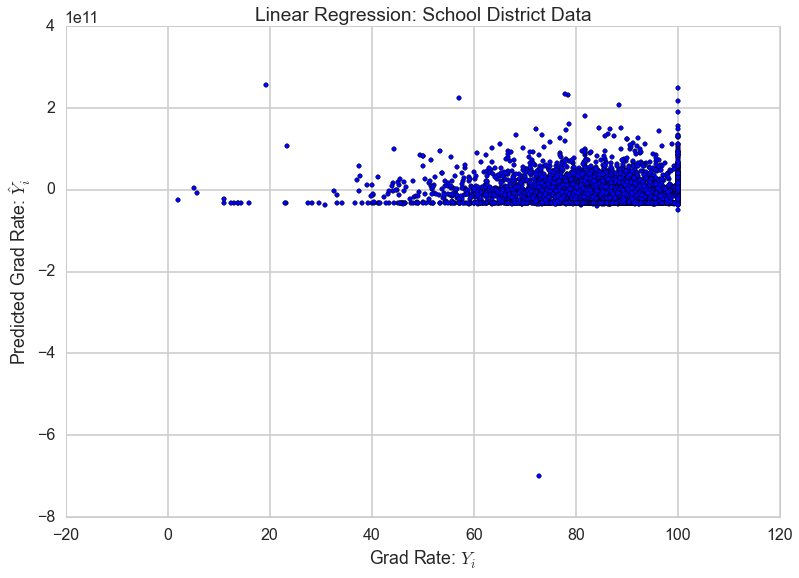

In [26]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Linear Regression: School District Data")

##### Lasso Regression

In [27]:
lasso = linear_model.Lasso()

In [28]:
lasso.fit(Xtrain, ytrain)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [29]:
print lasso.coef_
print lasso.intercept_

[-0.         -0.         -0.         -0.          0.          0.         -0.
  0.         -0.         -0.07155532 -0.         -0.          0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.         -0.
  0.04331447  0.          0.1146523  -0.         -0.          1.15325152
 -0.          0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.          0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
 -0.          0.          0.         -0.         -0.         -0.          0.
 -0.         -0.         -3.12752712  0.          0.         -0.10196873
  0.         -0.          0.         -0.          0.         -0.         -1.4147733
  0.         -0.         -0.          0.          0.          0.          0.
  0.          0.          0.         -0.         -0.          1.14453902
  1.67108045 -0.          0.         -0.          0.         -0.          0.
 -0.

In [30]:
pd.DataFrame(zip(dftouse[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:10]

,features,estimatedCoefficients
81,r_stud_reg_12_W_F,1.671080
26,tlocrev_percent,1.153252
80,r_stud_reg_12_W_M,1.144539
106,r_lrev_pt,0.207114
23,tcuresal_percent,0.114652
21,tcurinst_percent,0.043314
101,r_st_LEASS,-0.000000
102,r_st_SA,-0.000000
103,r_st_SASS,-0.000000
104,r_st_SSSS,-0.000000


In [31]:
pd.DataFrame(zip(dftouse[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:10]

,features,estimatedCoefficients
57,r_lunch_free,-3.127527
67,r_stud_re_B,-1.414773
60,r_stud_18,-0.101969
9,tfedrev_pp,-0.071555
109,r_lrev_it,0.000000
108,r_lrev_put,0.000000
107,r_lrev_gst,-0.000000
105,r_st_OSSS,0.000000
111,r_lrev_pgc,-0.000000
97,r_st_TGC,0.000000


r2

In [32]:
from sklearn import cross_validation
cross_validation.cross_val_score(lasso, Xtrain, ytrain, scoring='r2')

array([ 0.28917811,  0.30648578,  0.30567854])

Mean Squared Error

In [33]:
yp = lasso.predict(Xtest)
mean_squared_error(yp, ytest)

142.01165453857641

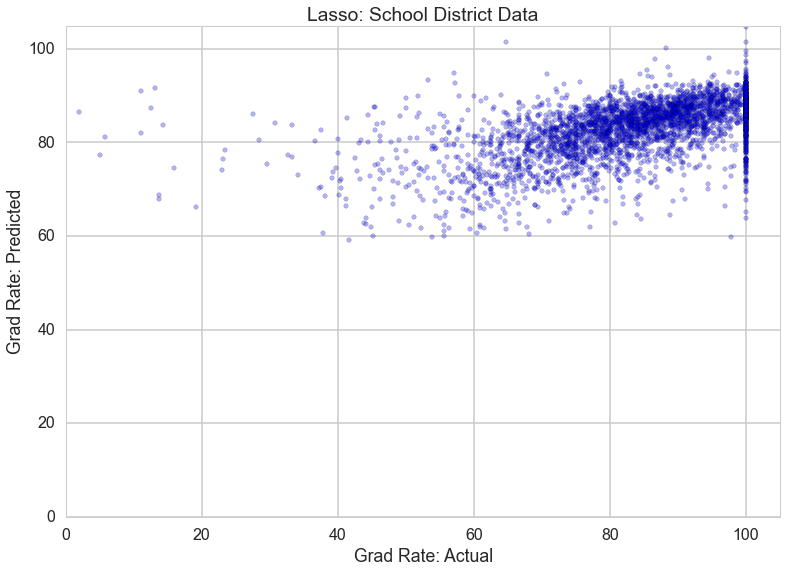

In [34]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Lasso: School District Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()    

We hit a wall at actual graduation rate of 100%, with some of our predictions varying from 70% to 100%.

##### Elastic Net Regression

In [35]:
elasticnet = linear_model.ElasticNet()
elasticnet.fit(Xtrain, ytrain)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [36]:
print elasticnet.coef_
print elasticnet.intercept_

[-0.15754261 -0.         -0.15636389 -0.          0.          0.         -0.
  0.02203522 -0.36828038 -0.14584563  0.         -0.          0.          0.
 -0.         -0.          0.         -0.02015836  0.          0.         -0.
  0.39217875  0.          0.34835184 -0.         -0.67829726  0.87674734
 -0.01112514  0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.          0.          0.          0.
  0.         -0.         -0.         -0.          0.          0.         -0.
 -0.          0.          0.         -0.         -0.         -0.          0.
 -0.21986609 -0.14526988 -1.8540049   0.          0.         -0.62131532
  0.2286506  -0.          0.03963397  0.          0.04666914 -0.
 -1.20353737  0.71765162 -0.         -0.          0.          0.01963492
  0.05027419  0.14124409  0.14973958  0.          0.14465554 -0.         -0.
  0.97868049  1.16366626 -0.          0.          0.          0.         -0.
  0.         -0.       

In [37]:
pd.DataFrame(zip(dftouse[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:20]

,features,estimatedCoefficients
81,r_stud_reg_12_W_F,1.163666
80,r_stud_reg_12_W_M,0.978680
26,tlocrev_percent,0.876747
68,r_stud_re_W,0.717652
106,r_lrev_pt,0.463341
21,tcurinst_percent,0.392179
23,tcuresal_percent,0.348352
61,r_stud_912,0.228651
116,r_lrev_slr,0.173974
75,r_stud_reg_12_AAP_F,0.149740


In [38]:
pd.DataFrame(zip(dftouse[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:20]

,features,estimatedCoefficients
57,r_lunch_free,-1.854005
67,r_stud_re_B,-1.203537
25,tfedrev_percent,-0.678297
60,r_stud_18,-0.621315
142,r_frev_title1,-0.437521
8,tsrev_pp,-0.368280
90,r_st_UT,-0.300363
55,r_ELL,-0.219866
122,r_lrev_molr,-0.199432
125,r_lrev_sale,-0.192702


In [39]:
cross_validation.cross_val_score(elasticnet, Xtrain, ytrain, scoring='r2')

array([ 0.30555789,  0.32563581,  0.33272892])

In [40]:
yp = elasticnet.predict(Xtest)
mean_squared_error(yp, ytest)

137.95194215490673

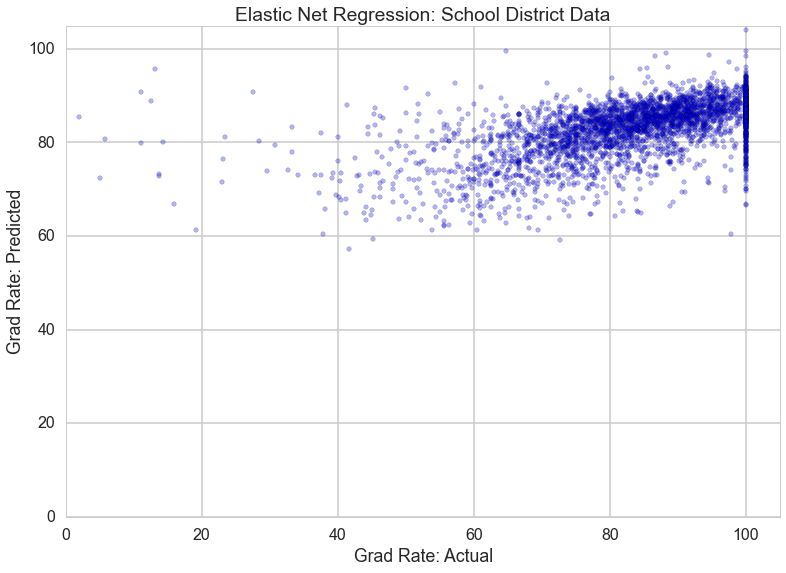

In [41]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Elastic Net Regression: School District Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()    

We hit a wall at actual graduation rate of 100% again, with predictions between 70% and 100%.  Of our three models of school district data only, elastic net provides the best results.

## Predicting graduation based on previous year graduation

We now add previous years of graduation data into our models to see if they outperform the model of school district data alone.  We expect that adding in previous years of graduation data will outperform the models of school district data alone.

In [65]:
dftouse.fillna(value=0,inplace=True)

As we add in previous years of data, some of those previous years do not have data for some of the school districts.  Therefore, the row counts will drop.

In [66]:
dftouse = dftouse[dftouse['gradrate0607']>0]
print 'Has 0607 Grad Data: ' + str(len(dftouse))
dftouse = dftouse[dftouse['gradrate0708']>0]
print 'Has 0708 Grad Data: ' + str(len(dftouse))
dftouse = dftouse[dftouse['gradrate0809']>0]
print 'Has 0809 Grad Data: ' + str(len(dftouse))

Has 0607 Grad Data: 9745
Has 0708 Grad Data: 9745
Has 0809 Grad Data: 9745


In [67]:
dftouse.shape

(9745, 160)

In [68]:
gradpred = dftouse.copy(deep=True)

In [69]:
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)

In [70]:
#CITATION: From HW3
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [71]:
# make sure we didn't get unlucky in our mask selection
print "% Graduation in Training:", np.mean(dftouse['afgr'][mask])
print "% Graduation in Testing:", np.mean(dftouse['afgr'][~mask])

% Graduation in Training: 83.1847969506
% Graduation in Testing: 83.2558481532


In [72]:
Xmatrix=dftouse[['gradrate0607', 'gradrate0708', 'gradrate0809']].values
Yresp=dftouse['afgr'].values

In [73]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

##### Linear Regression - 0607, 0708, and 0809

You have multiple previous years of school district graduation data available to you, and you want to add all of them into the model to predict graduation outcome.  This would be like saying, I want to predict school year 2014-2015 graduation rates, and I have 2013-2014, 2012-2013, and 2011-2012 school years of graduation rates available.  This is not a realistic scenario for the general public - the latest school year of graduation rate data publically available is 2009-2010.  That means there is a 5 year lapse in data availability, which would not make this regression possible to the general public if it we were the year 2009-2010.

In [74]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [75]:
print lm.intercept_
print lm.coef_

20.433000771
[ 0.14606539  0.26609439  0.35518108]


In [76]:
pd.DataFrame(zip(dftouse[['gradrate0607', 'gradrate0708', 'gradrate0809']].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,gradrate0607,0.146065
1,gradrate0708,0.266094
2,gradrate0809,0.355181


In [77]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.5026156 ,  0.503969  ,  0.50528951])

In [78]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

76.198179122093023

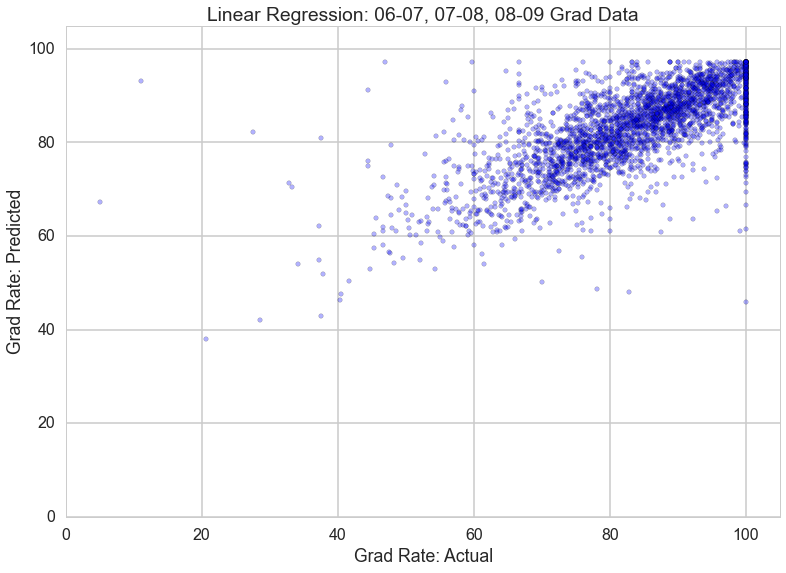

In [79]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: 06-07, 07-08, 08-09 Grad Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

This model outperforms all other models created thus far.  It hits the same wall at 100% graduation as the other models.  As noted earlier, this is not a realistic scenario because the most recent data that would have been available during school year 2009-2010 would have been 2004-2005.

##### Linear Regression - 0708 and 0809

This model assumes you have the two most current previous years of data available to you.

In [80]:
Xmatrix=dftouse[['gradrate0708', 'gradrate0809']].values
Yresp=dftouse['afgr'].values

In [81]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [82]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [83]:
print lm.intercept_
print lm.coef_

22.5459890541
[ 0.33505796  0.40571321]


In [84]:
pd.DataFrame(zip(dftouse[['gradrate0708', 'gradrate0809']].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,gradrate0708,0.335058
1,gradrate0809,0.405713


In [85]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.48747423,  0.4958983 ,  0.49706645])

In [86]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

78.385484167334127

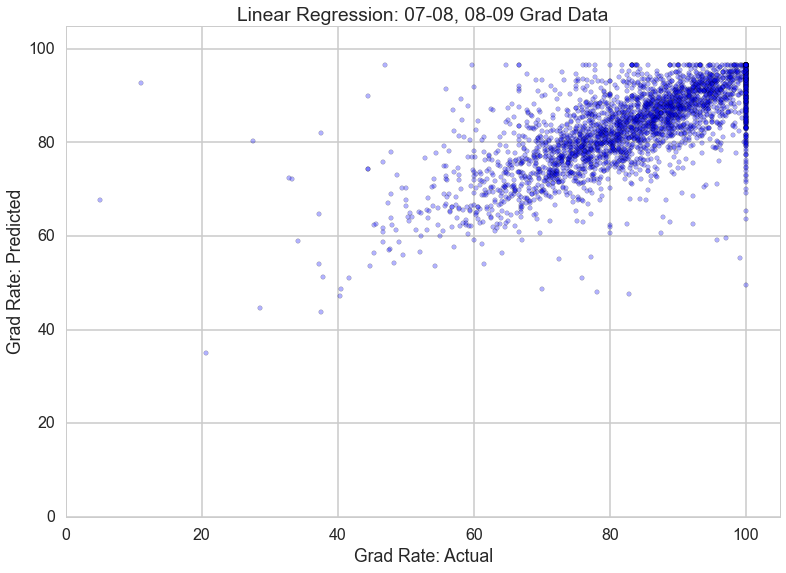

In [87]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: 07-08, 08-09 Grad Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

This model is less accurate than having 3 years of graduation data available, yet still more accurate than all of our previous models.

##### Linear Regression - 0809 Only

This model assumes you have the most recent previous year available.

In [88]:
Xmatrix=dftouse[['gradrate0809']].values
Yresp=dftouse['afgr'].values

In [89]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [90]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [91]:
print lm.intercept_
print lm.coef_

30.2418106285
[ 0.64519768]


In [92]:
pd.DataFrame(zip(dftouse[['gradrate0809']].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,gradrate0809,0.645198


In [93]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.41338085,  0.44128474,  0.432911  ])

In [94]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

86.844320323536508

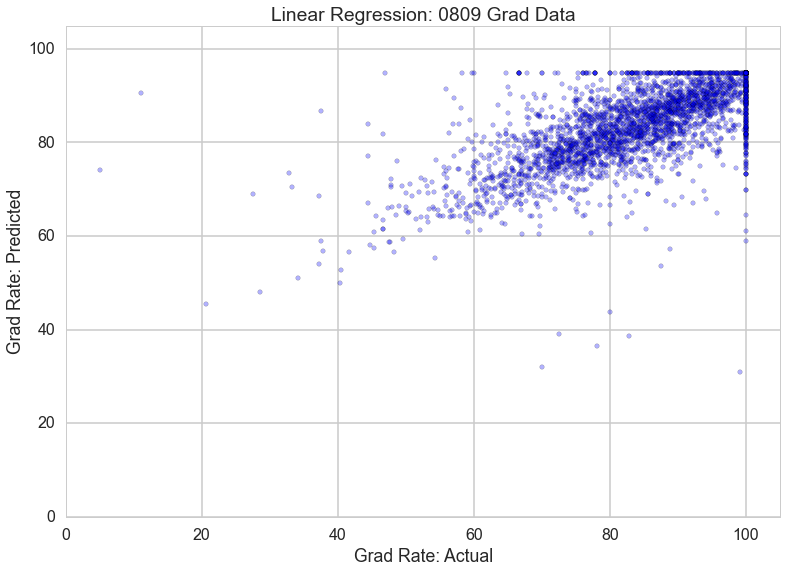

In [95]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: 0809 Grad Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

This model performs worse than the two previous.  It hits a wall at both actual grad rate and predicted grad rate.

##### Linear Regression - 0708 Only

This model assumes two years prior data available only.

In [96]:
Xmatrix=dftouse[['gradrate0708']].values
Yresp=dftouse['afgr'].values

In [97]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [98]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [99]:
print lm.intercept_
print lm.coef_

33.6538360041
[ 0.60685348]


In [100]:
pd.DataFrame(zip(dftouse[['gradrate0708']].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,gradrate0708,0.606853


In [101]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.41151975,  0.39787917,  0.40689306])

In [102]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

97.98096303229589

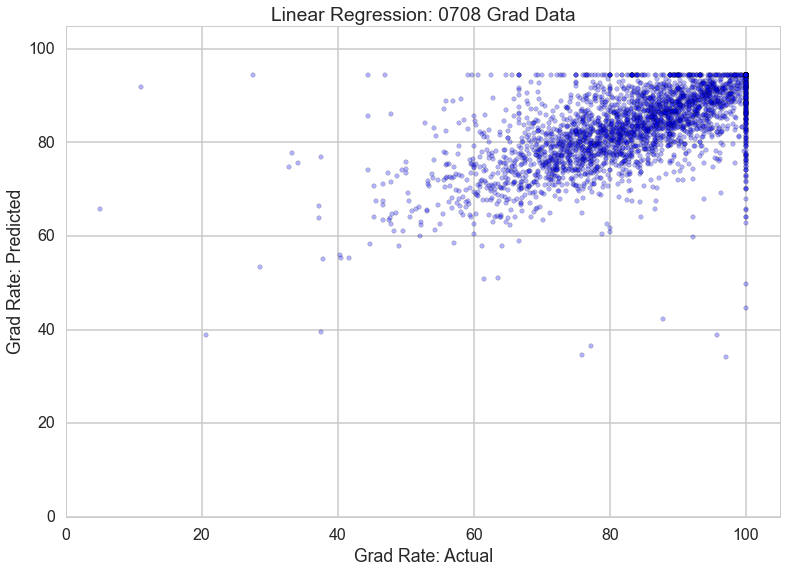

In [103]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: 0708 Grad Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

##### Linear Regression - 0607 Only

This model assumes three years prior data available only.

In [104]:
Xmatrix=dftouse[['gradrate0607']].values
Yresp=dftouse['afgr'].values

In [105]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [106]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [107]:
print lm.intercept_
print lm.coef_

38.1943943498
[ 0.55277555]


In [108]:
pd.DataFrame(zip(dftouse[['gradrate0607']].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,gradrate0607,0.552776


In [109]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.37649973,  0.33539453,  0.31718309])

In [110]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

101.31422973641487

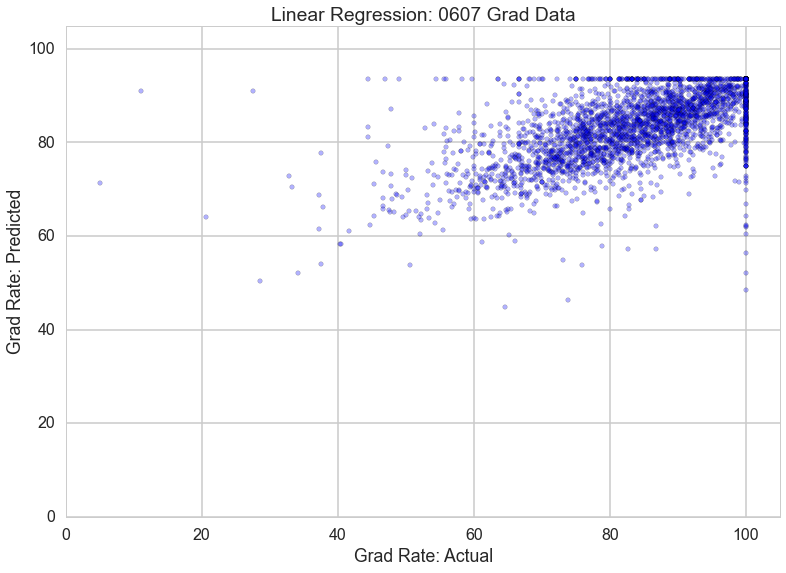

In [111]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: 0607 Grad Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

If you only have graduation data available for 3 years prior, the performance is the worst.  Again, walls at actual and predicted 100% graduation rate.  This model overpredicts, telling a school district that it is doing better than it is, which is not a good scenario.

## Predicting graduation based on previous year graduation and all other factors

If we married the previous years of graduation data and the school district data, could we create the best model?  Is it better than just graduation rate alone?

In [112]:
lcols=list(dftouse.columns)
lcols.remove('RESP_High_Graduation')
lcols.remove('RESP_Low_Graduation')
lcols.remove('afgr')

In [113]:
Xmatrix=dftouse[lcols].values
Yresp=dftouse['afgr'].values

In [114]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

##### Linear Regression

In [115]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [116]:
print lm.intercept_
print lm.coef_

28.0987203611
[ -7.43939689e+00   1.28839672e-01   7.18807472e+00   1.24408160e-01
   1.33822896e-01   5.44357118e-02  -4.57063664e+00   3.55730441e+00
   2.16073962e+00   2.13020094e+00  -5.61946790e+00  -6.04136092e+00
  -1.23560862e+00   2.92721653e+00   7.30855956e-02  -2.25805738e+00
   1.10450328e+00   2.29880124e-01   1.60854732e+01  -5.61946790e+00
  -5.40831808e-01   7.25578890e+00   2.02355203e+00  -1.11882380e+00
   4.10191814e+00  -7.45814458e+00  -1.76156973e+01  -1.58916197e+01
  -8.01238949e+00  -1.19168480e+01  -1.19800601e+01  -5.10187015e+00
   7.31032001e+00   1.38421225e+01   7.25894706e+00  -3.00325745e+00
  -2.24287545e+00  -2.15513029e-01   6.80814781e-01   8.33629405e-01
   1.15633168e+00   2.25546585e+00   1.01560850e-01  -1.84912256e-01
   3.26301897e-01  -6.08869603e-02   3.53340676e-01  -5.10187015e+00
   2.85513095e+00   2.24673920e+00  -2.09100679e-01   1.08897022e-01
   1.00203657e-01   1.03131197e+00   1.67236509e+00  -1.88203597e-01
  -2.48666997e-01  -

In [117]:
pd.DataFrame(zip(dftouse[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:20]

,features,estimatedCoefficients
91,r_st_TS,34.687213
18,tcurelsc_pp,16.085473
33,i_fin_sdlc_elem_sec,13.842123
32,i_fin_sdlc_sec,7.310320
34,i_fin_sdlc_voc,7.258947
21,tcurinst_percent,7.255789
2,num_pub_schools,7.188075
68,r_stud_re_W,5.268990
24,tcurssvc_percent,4.101918
148,r_frev_ao,3.823908


In [118]:
pd.DataFrame(zip(dftouse[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:20]

,features,estimatedCoefficients
26,tlocrev_percent,-17.615697
27,tsrev_percent,-15.891620
30,i_agency_type_regional_education_services,-11.980060
29,i_agency_type_local_school_district_sup_union,-11.916848
89,r_st_ST,-11.599668
92,r_st_IA,-8.608899
28,i_agency_type_local_school_district,-8.012389
25,tfedrev_percent,-7.458145
0,num_schools,-7.439397
11,tcurssv_pp,-6.041361


In [119]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.52105193,  0.25679614,  0.54093988])

In [120]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

75.128250193365716

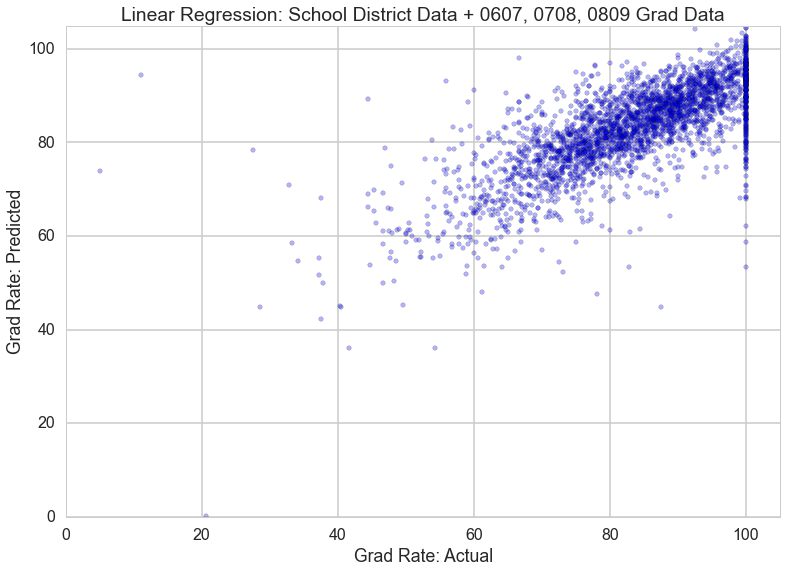

In [121]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: School District Data + 0607, 0708, 0809 Grad Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

##### Lasso Regression

In [324]:
lasso = linear_model.Lasso()

In [325]:
lasso.fit(Xtrain, ytrain)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [326]:
pd.DataFrame(zip(dftouse[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:10]

,features,estimatedCoefficients
81,r_stud_reg_12_W_F,0.383764
156,gradrate0809,0.362749
155,gradrate0708,0.252631
154,gradrate0607,0.139018
108,r_lrev_put,0.000000
101,r_st_LEASS,0.000000
102,r_st_SA,-0.000000
103,r_st_SASS,-0.000000
104,r_st_SSSS,-0.000000
105,r_st_OSSS,0.000000


In [327]:
pd.DataFrame(zip(dftouse[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:10]

,features,estimatedCoefficients
57,r_lunch_free,-0.071872
100,r_st_LEA,-0.000000
101,r_st_LEASS,0.000000
102,r_st_SA,-0.000000
103,r_st_SASS,-0.000000
104,r_st_SSSS,-0.000000
105,r_st_OSSS,0.000000
106,r_lrev_pt,0.000000
107,r_lrev_gst,-0.000000
108,r_lrev_put,0.000000


In [328]:
cross_validation.cross_val_score(lasso, Xtrain, ytrain, scoring='r2')

array([ 0.52696384,  0.50808201,  0.56339474])

In [329]:
yp = lasso.predict(Xtest)
mean_squared_error(yp, ytest)

85.431602930778709

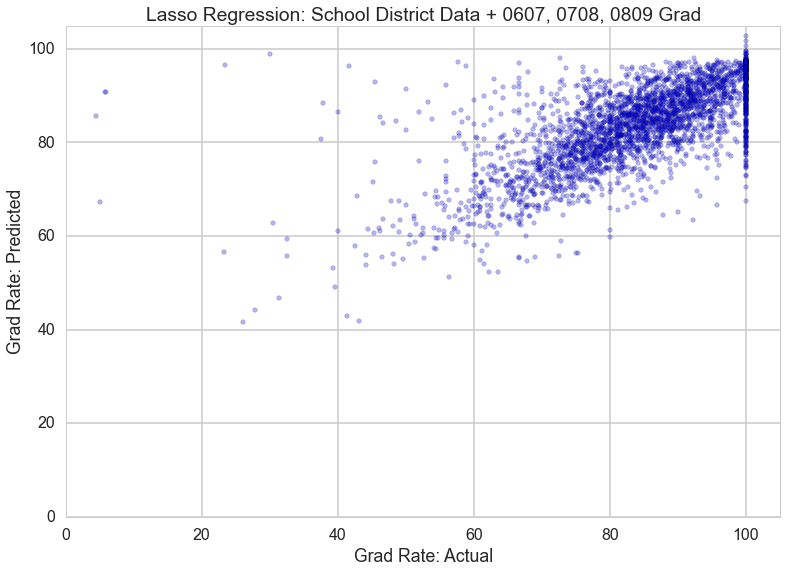

In [330]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Lasso Regression: School District Data + 0607, 0708, 0809 Grad")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

##### Elastic Net Regression

In [122]:
elasticnet = linear_model.ElasticNet()
elasticnet.fit(Xtrain, ytrain)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [123]:
print elasticnet.coef_
print elasticnet.intercept_

[-0.         -0.         -0.         -0.          0.          0.          0.
  0.         -0.         -0.          0.          0.         -0.          0.
 -0.          0.          0.         -0.          0.          0.         -0.
  0.         -0.          0.         -0.         -0.          0.18770879
 -0.          0.         -0.         -0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.          0.          0.          0.
  0.         -0.         -0.          0.         -0.          0.         -0.
  0.          0.         -0.          0.         -0.         -0.          0.
 -0.         -0.         -0.24993557  0.          0.         -0.          0.
  0.          0.         -0.          0.          0.         -0.2044236   0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -0.         -0.          0.33605209  0.46638057
 -0.          0.          0.          0.          0.         -0.         -0.
 -0.   

In [124]:
pd.DataFrame(zip(dftouse[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:10]

,features,estimatedCoefficients
81,r_stud_reg_12_W_F,0.466381
80,r_stud_reg_12_W_M,0.336052
156,gradrate0809,0.334610
155,gradrate0708,0.247280
26,tlocrev_percent,0.187709
154,gradrate0607,0.128515
126,r_lrev_ff,0.010145
101,r_st_LEASS,-0.000000
102,r_st_SA,-0.000000
103,r_st_SASS,-0.000000


In [125]:
pd.DataFrame(zip(dftouse[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:10]

,features,estimatedCoefficients
57,r_lunch_free,-0.249936
67,r_stud_re_B,-0.204424
124,r_lrev_rr,-0.100394
119,r_lrev_osalserv,-0.017036
0,num_schools,-0.000000
100,r_st_LEA,-0.000000
101,r_st_LEASS,-0.000000
102,r_st_SA,-0.000000
103,r_st_SASS,-0.000000
104,r_st_SSSS,-0.000000


In [126]:
cross_validation.cross_val_score(elasticnet, Xtrain, ytrain, scoring='r2')

array([ 0.51832816,  0.52019994,  0.51872589])

In [127]:
yp = elasticnet.predict(Xtest)
mean_squared_error(yp, ytest)

73.518125985674999

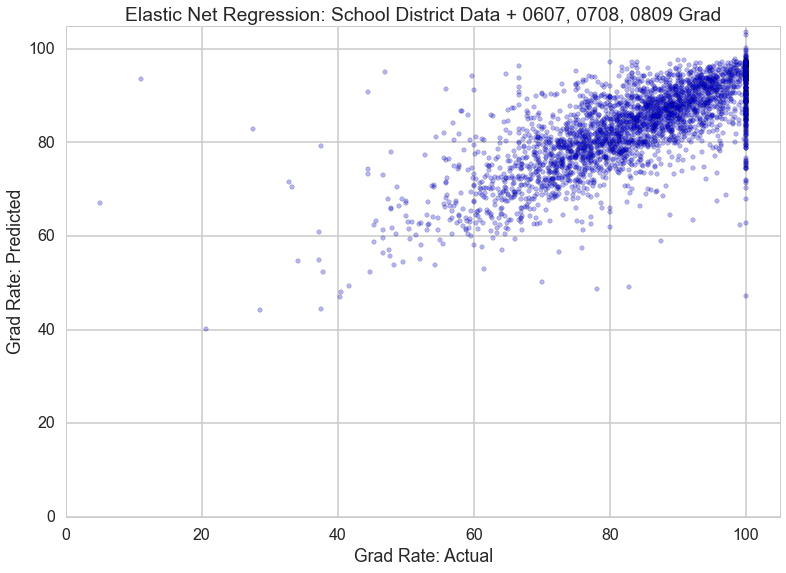

In [128]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Elastic Net Regression: School District Data + 0607, 0708, 0809 Grad")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()    

### Creating a best model

We use the columns selected by our best model (elastic net) to inform what features we should select for a linear regression and see if we can beat any of the models with graduation rate in them.

In [143]:
lcols=['r_stud_reg_12_W_F', 'r_stud_reg_12_W_M', 'tlocrev_percent', 'r_stud_re_W', 'r_lrev_pt', 'r_lunch_free', 'r_stud_re_B', 'tfedrev_percent', 'r_stud_18', 'tsrev_pp', 'tcuresal_percent', 'r_frev_title1', 'tcurinst_percent', 'r_lrev_molr']

In [144]:
Xmatrix=dftouse[lcols].values
Yresp=dftouse['afgr'].values

In [145]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [146]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [147]:
print lm.intercept_
print lm.coef_

82.877891759
[ 1.89812212  1.94644251  0.88568581 -0.43549697  0.67124702 -2.6498438
 -1.967767   -0.73347477 -1.20889019 -0.761516    0.9129093  -0.72080734
  0.13304378 -0.74170863]


In [148]:
pd.DataFrame(zip(dftouse[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,r_stud_reg_12_W_F,1.898122
1,r_stud_reg_12_W_M,1.946443
2,tlocrev_percent,0.885686
3,r_stud_re_W,-0.435497
4,r_lrev_pt,0.671247
5,r_lunch_free,-2.649844
6,r_stud_re_B,-1.967767
7,tfedrev_percent,-0.733475
8,r_stud_18,-1.208890
9,tsrev_pp,-0.761516


In [149]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.31560378,  0.36557518,  0.32627772])

In [150]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

101.44789672720773

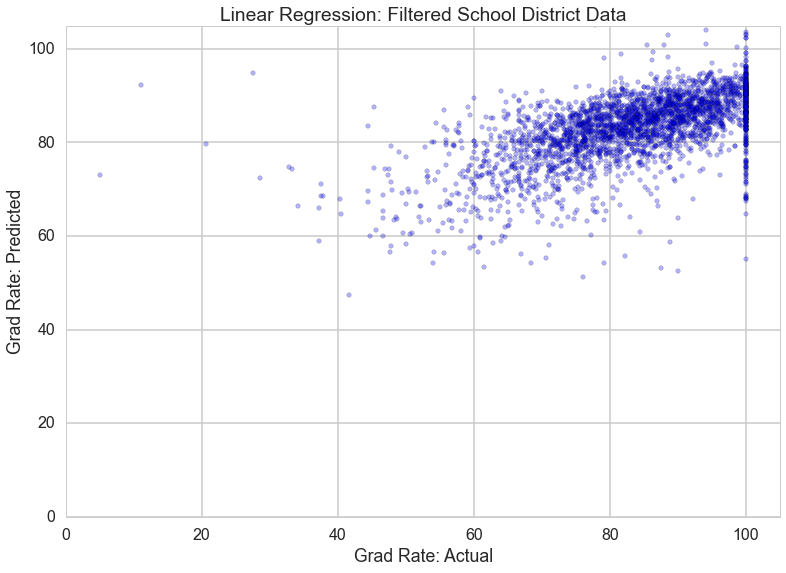

In [142]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: Filtered School District Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

The mean squared error for the 0607 graduation rate only model and the filtered school district model are nearly identical.  Therefore, if we only have school district information, its predictive ability is akin to having a graduation rate 3 years back.  We could posit that in the scenario of not receiving public graduation data until 5 years later, we could use school district characteristics to predict the graduation rates 3 years in advance until such time that better data is available.

### Findings

Linear Regression - 0607 Only and Best Model have very similar MSE.  The 0607 Only model overpredicts.  The Best Model underpredicts.  Underprediction is better than overprediction in this scenario - it is disadvantageous if the school district thinks it is performing better than it is.

This brings to mind an interesting scenario.  We started this project with 09-10 graduation data because it was the newest data available.  Given the similarity in the 0607 Only and Best model, if all we have is school district information, it may be worthwhile checking if we can predict with the same quality as the 0607 Only model.  If quality is similar, we might be able to predict 12-13 graduation rates several years before they are released to the public.

We go back to ELSI to download 0607 school district information to test this out.

## Trying 2009-2010 predictions using 2006-2007 data

In [196]:
dftouse0607 = pd.read_csv("data/finaldata/dftouse_0607_with0910grad.csv")

In [197]:
dftouse0607.shape

(9582, 417)

In [198]:
STANDARDIZABLE = ['num_students', 'num_schools','num_charter_schools','num_pub_schools','tcuresal_percent','pupil_teacher_ratio_dist', 'pupil_teacher_ratio_ps', 'totalrev_pp','tlocrev_pp','tsrev_pp','tfedrev_pp','tcurinst_pp','tcurssv_pp','tcuroth_pp','tcursalary_pp','tcurbenefits_pp','totalexp_pp','tcapout_pp','tnonelse_pp','tcurelsc_pp','instexp_pp','tcurinst_percent','tcuroth_percent','tcurelsc_percent','tcurssvc_percent','tfedrev_percent','tlocrev_percent','tsrev_percent','r_ELL','r_IEP','r_lunch_free','r_lunch_reduced','r_stud_PKK','r_stud_18','r_stud_912','r_stud_re_M','r_stud_re_F','r_stud_re_AIAN','r_stud_re_AAP','r_stud_re_H','r_stud_re_B','r_stud_re_W','r_stud_re_Total','r_stud_reg_12_AIAN_M','r_stud_reg_12_AIAN_F','r_stud_reg_12_AAP_M','r_stud_reg_12_AAP_F','r_stud_reg_12_H_M','r_stud_reg_12_H_F','r_stud_reg_12_B_M','r_stud_reg_12_B_F','r_stud_reg_12_W_M','r_stud_reg_12_W_F','r_stud_reg_12_HNPI_M','r_stud_reg_12_HNPI_F','r_stud_reg_12_Two_M','r_stud_reg_12_Two_F','r_st_PKT','r_st_KT','r_st_ET','r_st_ST','r_st_UT','r_st_TS','r_st_IA','r_st_IC','r_st_EGC','r_st_SGC','r_st_TGC','r_st_LMS','r_st_LMSS','r_st_LEA','r_st_LEASS','r_st_SA','r_st_SASS','r_st_SSSS','r_st_OSSS','r_lrev_pt','r_lrev_gst','r_lrev_put','r_lrev_it','r_lrev_aot','r_lrev_pgc','r_lrev_cc','r_lrev_oss','r_lrev_tui','r_lrev_trans','r_lrev_slr','r_lrev_ts','r_lrev_sar','r_lrev_osalserv','r_lrev_sfns','r_lrev_ie','r_lrev_molr','r_lrev_sp','r_lrev_rr','r_lrev_sale','r_lrev_ff','r_lrev_pc','r_srev_gfa','r_srev_sep','r_srev_trans','r_srev_sip','r_srev_cbsp','r_srev_vep','r_srev_codsp','r_srev_bep','r_srev_gt','r_srev_slp','r_srev_aor','r_srev_splea','r_srev_osp','r_srev_ns','r_frev_title1','r_frev_dis','r_frev_cna','r_frev_ems','r_frev_dfs','r_frev_voc','r_frev_ao','r_frev_ns','r_frev_ia','r_frev_be','r_frev_na','r_frev_aofed']
print STANDARDIZABLE

['num_students', 'num_schools', 'num_charter_schools', 'num_pub_schools', 'tcuresal_percent', 'pupil_teacher_ratio_dist', 'pupil_teacher_ratio_ps', 'totalrev_pp', 'tlocrev_pp', 'tsrev_pp', 'tfedrev_pp', 'tcurinst_pp', 'tcurssv_pp', 'tcuroth_pp', 'tcursalary_pp', 'tcurbenefits_pp', 'totalexp_pp', 'tcapout_pp', 'tnonelse_pp', 'tcurelsc_pp', 'instexp_pp', 'tcurinst_percent', 'tcuroth_percent', 'tcurelsc_percent', 'tcurssvc_percent', 'tfedrev_percent', 'tlocrev_percent', 'tsrev_percent', 'r_ELL', 'r_IEP', 'r_lunch_free', 'r_lunch_reduced', 'r_stud_PKK', 'r_stud_18', 'r_stud_912', 'r_stud_re_M', 'r_stud_re_F', 'r_stud_re_AIAN', 'r_stud_re_AAP', 'r_stud_re_H', 'r_stud_re_B', 'r_stud_re_W', 'r_stud_re_Total', 'r_stud_reg_12_AIAN_M', 'r_stud_reg_12_AIAN_F', 'r_stud_reg_12_AAP_M', 'r_stud_reg_12_AAP_F', 'r_stud_reg_12_H_M', 'r_stud_reg_12_H_F', 'r_stud_reg_12_B_M', 'r_stud_reg_12_B_F', 'r_stud_reg_12_W_M', 'r_stud_reg_12_W_F', 'r_stud_reg_12_HNPI_M', 'r_stud_reg_12_HNPI_F', 'r_stud_reg_12_Two_M

In [199]:
INDICATORS = []
for v in dftouse0607.columns:
    l=np.unique(dftouse0607[v])
    if len(l) <= 10:
        INDICATORS.append(v)
        
INDICATORS.remove('RESP_High_Graduation')        
INDICATORS.remove('RESP_Low_Graduation')  
INDICATORS.remove('Metro Status Code [District] 2009-10')
INDICATORS.remove('Gender Unknown Students [Public School] 2009-10')
print INDICATORS

['i_agency_type_local_school_district', 'i_agency_type_local_school_district_sup_union', 'i_agency_type_sup_union_admin', 'i_agency_type_regional_education_services', 'i_agency_type_state_operated_institution', 'i_agency_type_charter_school_agency', 'i_agency_type_other_education_agency', 'i_fin_sdlc_elem', 'i_fin_sdlc_sec', 'i_fin_sdlc_elem_sec', 'i_fin_sdlc_voc', 'i_fin_sdlc_nonop', 'i_fin_sdlc_ed_serv', 'i_ucl_city_large', 'i_ucl_city_mid', 'i_ucl_city_small', 'i_ucl_suburb_large', 'i_ucl_suburb_mid', 'i_ucl_suburb_small', 'i_ucl_town_fringe', 'i_ucl_town_distant', 'i_ucl_town_remote', 'i_ucl_rural_fringe', 'i_ucl_rural_distant', 'i_ucl_rural_remote', 'i_cs_all_charter', 'i_cs_charter_noncharter', 'i_cs_all_noncharter', 'i_ma_ne_nr', 'i_ma_metropolitan', 'i_ma_micropolitan', 'i_lgo_10', 'i_lgo_11', 'i_lgo_12', 'i_lgo_1', 'i_lgo_2', 'i_lgo_3', 'i_lgo_4', 'i_lgo_5', 'i_lgo_6', 'i_lgo_7', 'i_lgo_8', 'i_lgo_9', 'i_lgo_K', 'i_lgo_PK', 'i_lgo_U']


In [200]:
itrain, itest = train_test_split(xrange(dftouse0607.shape[0]), train_size=0.7)

In [201]:
#CITATION: From HW3
mask=np.ones(dftouse0607.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [202]:
# make sure we didn't get unlucky in our mask selection
print "% Graduation in Training:", np.mean(dftouse0607['afgr'][mask])
print "% Graduation in Testing:", np.mean(dftouse0607['afgr'][~mask])

% Graduation in Training: 81.3158789325
% Graduation in Testing: 81.6722086957


In [203]:
#CITATION: From HW3
mask

array([ True,  True,  True, ...,  True, False,  True], dtype=bool)

In [204]:
#CITATION: From HW3
mask.shape, mask.sum()

((9582,), 6707)

In [205]:
dftouse0607.head()

,agency,state,state_abbr,agency_id_nces,county,county_number,num_schools,num_charter_schools,num_pub_schools,report_years,no_report_years,address,city,add_state,zipcode,﻿Agency Name_DEL,latitude,longitude,agency_id_state,Metro Status Code [District] 2009-10,congressional_code,census_id,offered_g_lowest,num_students,Total Students - Calculated Sum of Reported Grade Totals [Public School] 2009-10,Migrant Students in Summer Programs (**) [District] 2009-10,Migrant Students (**) [Public School] 2009-10,Gender Unknown Students [Public School] 2009-10,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,...,r_lrev_gst,r_lrev_put,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,afgr0910
0,21ST CENTURY CYBER CS,Pennsylvania,PA,4200091,CHESTER,42029,1,1,1,2001-2013,1986-2000,805 SPRINGDALE DR,EXTON,PA,19341,21ST CENTURY CYBER CS,40.002611,-75.689137,124150002,2-CBSA/MSA- not primarily its principal/centra...,4206,NaN,6th Grade,467,467,NaN,NaN,0,29.3,28.7,9011,8676,245,90,4426,2898,0,3394,1196,7785,461,0,7324,4426,16.3,60.4,0.0,46.3,39.6,1.0,...,0.000000,0,0.000000,0,0,0.00000,0.999017,0.000000,0,0.000000,0.000000,0.000000,0.000737,0,0.000000,0.000246,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.939130,0.000000,0.000000,0.000000,0,0,0.000000,0.060870,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,1.000000,1,0,100.0
1,A+ ACADEMY,Texas,TX,4800203,DALLAS,48113,1,1,1,2000-2013,1986-1999,8225 BRUTON RD,DALLAS,TX,75217,A+ ACADEMY,32.690593,-96.643398,057829,1-Principal/central city of CBSA/MSA,4830,NaN,Prekindergarten,994,994,NaN,NaN,0,13.5,13.5,9040,462,7798,781,4751,2960,362,5179,523,8072,0,0,8072,4751,6.5,58.8,4.5,64.2,36.7,8.6,...,0.000000,0,0.000000,0,0,0.00000,0.000000,0.000000,0,0.172113,0.000000,0.000000,0.000000,0,0.000000,0.827887,0.000000,0.000000,0.000000,0,0.000000,0.916398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000516,0.035221,0.041414,0.006451,0,0.000000,0.199742,0.355670,0.068299,0.001289,0.000000,0.375000,0,0,0,0,0.000000,0,0,55.7
2,A-C CENTRAL CUSD 262,Illinois,IL,1700105,CASS,17017,3,0,3,1989-2013,1986-1988,501 EAST BUCHANAN ST,ASHLAND,IL,62612,A-C CENTRAL CUSD 262,39.891262,-90.010711,46-009-2620-26,3-Does not serve a CBSA/MSA,1718,1.450092e+13,Prekindergarten,483,483,NaN,0,0,10.3,10.3,9327,4292,4532,503,3950,3280,383,4826,1133,7857,27,0,7613,3950,14.9,51.9,5.0,63.4,43.1,5.4,...,0.000000,0,0.000000,0,0,0.00000,0.017366,0.000000,0,0.045345,0.010613,0.011577,0.000000,0,0.007718,0.010130,0.031838,0.000000,0.000000,0,0.000000,0.704888,0.031521,0.160347,0.000000,0.000000,0.005025,0.000000,0,0,0.000914,0.010964,0.081316,0.005025,0,0.263374,0.000000,0.238683,0.000000,0.004115,0.000000,0.288066,0,0,0,0,0.205761,1,0,70.7
3,A-H-S-T COMM SCHOOL DISTRICT,Iowa,IA,1904080,POTTAWATTAMIE,19155,2,0,2,1986-2013,NaN,768 SOUTH MAPLE ST,AVOCA,IA,51521,A-H-S-T COMM SCHOOL DISTRICT,41.471423,-95.341045,780441 000,2-CBSA/MSA- not primarily its principal/centra...,1905,1.650780e+13,Prekindergarten,605,605,NaN,0,0,13.5,13.5,10681,5056,5246,379,5028,2192,309,4864,1258,8712,1106,31,7529,5028,16.7,66.8,4.1,64.6,29.1,3.5,...,0.154299,0,0.073227,0,0,0.00000,0.059170,0.002288,0,0.039555,0.004904,0.001308,0.000000,0,0.016672,0.022

In [206]:
#CITATION: From HW3
from sklearn.preprocessing import StandardScaler

for col in STANDARDIZABLE:
    #print col
    valstrain=dftouse0607[col].values[mask]
    valstest=dftouse0607[col].values[~mask]
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    outtest=scaler.fit_transform(valstest)
    out=np.empty(mask.shape[0])
    out[mask]=outtrain
    out[~mask]=outtest
    dftouse0607[col]=out

In [207]:
dftouse0607.head()

,agency,state,state_abbr,agency_id_nces,county,county_number,num_schools,num_charter_schools,num_pub_schools,report_years,no_report_years,address,city,add_state,zipcode,﻿Agency Name_DEL,latitude,longitude,agency_id_state,Metro Status Code [District] 2009-10,congressional_code,census_id,offered_g_lowest,num_students,Total Students - Calculated Sum of Reported Grade Totals [Public School] 2009-10,Migrant Students in Summer Programs (**) [District] 2009-10,Migrant Students (**) [Public School] 2009-10,Gender Unknown Students [Public School] 2009-10,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,...,r_lrev_gst,r_lrev_put,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,afgr0910
0,21ST CENTURY CYBER CS,Pennsylvania,PA,4200091,CHESTER,42029,-0.404299,0.593108,-0.402160,2001-2013,1986-2000,805 SPRINGDALE DR,EXTON,PA,19341,21ST CENTURY CYBER CS,40.002611,-75.689137,124150002,2-CBSA/MSA- not primarily its principal/centra...,4206,NaN,6th Grade,-0.297840,467,NaN,NaN,0,1.760153,2.514193,-0.506624,0.786616,-1.962099,-0.887877,-0.666973,-0.335233,-1.486809,-1.153220,-0.717369,-0.697201,-0.272632,-0.370034,-0.672633,-0.669157,-0.511149,0.026423,-2.337158,-1.505070,0.914061,-1.115446,...,-0.212068,-0.160886,-0.265719,-0.276127,-0.263812,-0.296497,8.698384,-0.206030,-0.141033,-1.202398,-0.310119,-0.555071,-0.218720,-0.059711,-0.775763,-0.500907,-0.270498,-0.182511,-0.138517,-0.291216,-0.241332,-3.306503,-0.566274,-0.493833,16.620948,-0.288535,-0.276900,-0.30564,-0.158656,-0.186434,-0.148764,-0.104180,-0.467340,-0.232444,-0.201673,-1.484199,-0.960329,-1.910459,-0.680313,-0.375561,-0.285683,-0.750963,-0.41399,-0.192432,-0.147629,-0.189788,8.844582,1,0,100.0
1,A+ ACADEMY,Texas,TX,4800203,DALLAS,48113,-0.404299,0.593108,-0.402160,2000-2013,1986-1999,8225 BRUTON RD,DALLAS,TX,75217,A+ ACADEMY,32.690593,-96.643398,057829,1-Principal/central city of CBSA/MSA,4830,NaN,Prekindergarten,-0.248871,994,NaN,NaN,0,-0.115385,0.044050,-0.500578,-1.028873,0.865961,-0.068281,-0.511712,-0.290743,-0.211776,-0.274417,-1.373869,-0.636503,-0.521709,-0.370034,-0.452487,-0.518782,-2.134270,-0.187914,-0.011558,0.584428,0.406175,0.147158,...,-0.212068,-0.160886,-0.265719,-0.276127,-0.263812,-0.296497,-0.349250,-0.206030,-0.141033,3.528200,-0.310119,-0.555071,-0.248156,-0.059711,-0.775763,9.419405,-0.270498,-0.182511,-0.138517,-0.291216,-0.241332,0.790439,-0.566274,-0.493833,-0.323708,-0.288535,-0.276900,-0.30564,-0.158656,-0.186434,-0.108105,-0.319927,0.002580,0.369679,-0.201673,-1.484199,0.042253,0.806309,0.532199,-0.297860,-0.285683,1.609712,-0.41399,-0.192432,-0.147629,-0.189788,-0.482553,0,0,55.7
2,A-C CENTRAL CUSD 262,Illinois,IL,1700105,CASS,17017,-0.278990,-0.100765,-0.278785,1989-2013,1986-1988,501 EAST BUCHANAN ST,ASHLAND,IL,62612,A-C CENTRAL CUSD 262,39.891262,-90.010711,46-009-2620-26,3-Does not serve a CBSA/MSA,1718,1.450092e+13,Prekindergarten,-0.296354,483,NaN,0,0,-0.495240,-0.475980,-0.440738,-0.182352,-0.356923,-0.398017,-0.894370,-0.061121,-0.137810,-0.448208,-0.778824,-0.681974,-0.507121,-0.370034,-0.587577,-0.889398,-0.743024,-1.112243,0.246842,0.491043,1.527028,-0.384465,...,-0.212068,-0.160886,-0.265719,-0.276127,-0.263812,-0.296497,-0.191973,-0.206030,-0.141033,0.043924,2.191469,-0.346937,-0.248156,-0.05

In [208]:
#CITATION: From HW3
lcols=STANDARDIZABLE+INDICATORS
print len(lcols)

170


In [209]:
#CITATION: From HW3
ccols=[]
for c in lcols:
    if c not in INDICATORS:
        ccols.append(c)
print len(ccols), len(INDICATORS)
ccols

124 46


['num_students',
 'num_schools',
 'num_charter_schools',
 'num_pub_schools',
 'tcuresal_percent',
 'pupil_teacher_ratio_dist',
 'pupil_teacher_ratio_ps',
 'totalrev_pp',
 'tlocrev_pp',
 'tsrev_pp',
 'tfedrev_pp',
 'tcurinst_pp',
 'tcurssv_pp',
 'tcuroth_pp',
 'tcursalary_pp',
 'tcurbenefits_pp',
 'totalexp_pp',
 'tcapout_pp',
 'tnonelse_pp',
 'tcurelsc_pp',
 'instexp_pp',
 'tcurinst_percent',
 'tcuroth_percent',
 'tcurelsc_percent',
 'tcurssvc_percent',
 'tfedrev_percent',
 'tlocrev_percent',
 'tsrev_percent',
 'r_ELL',
 'r_IEP',
 'r_lunch_free',
 'r_lunch_reduced',
 'r_stud_PKK',
 'r_stud_18',
 'r_stud_912',
 'r_stud_re_M',
 'r_stud_re_F',
 'r_stud_re_AIAN',
 'r_stud_re_AAP',
 'r_stud_re_H',
 'r_stud_re_B',
 'r_stud_re_W',
 'r_stud_re_Total',
 'r_stud_reg_12_AIAN_M',
 'r_stud_reg_12_AIAN_F',
 'r_stud_reg_12_AAP_M',
 'r_stud_reg_12_AAP_F',
 'r_stud_reg_12_H_M',
 'r_stud_reg_12_H_F',
 'r_stud_reg_12_B_M',
 'r_stud_reg_12_B_F',
 'r_stud_reg_12_W_M',
 'r_stud_reg_12_W_F',
 'r_stud_reg_12_

In [210]:
Xmatrix=dftouse0607[lcols].values
Yresp=dftouse0607['afgr'].values

In [211]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

##### Linear Regression

Performance expected to be poor - use as a justification for lasso and elastic net.

In [212]:
import sklearn.linear_model
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [213]:
print lm.intercept_
print lm.coef_

680988.428348
[  1.49918453e+00   7.91642808e+00   4.07763227e-01  -1.06946999e+01
   9.08097087e-02  -1.74166161e-01   2.83460127e-01   7.76430939e+02
  -7.31891954e+02  -4.31737148e+02  -1.36599037e+02   6.20454895e+02
   4.09260633e+02   8.29042558e+01   4.52212894e-01  -1.94661620e+00
  -1.25643603e+00   4.29362803e-01   1.53274287e-01  -9.98318136e+02
  -3.98064990e+00   1.29996410e+01   3.32279160e+00   4.46676491e-01
   9.87027007e+00  -1.16671458e+01  -3.26728287e+01  -3.26538654e+01
  -1.34288236e-01  -1.14339476e+00  -2.48444671e+00  -2.75731270e-01
   1.11570674e-01  -2.23107451e+00   1.68389383e+00  -1.56619697e+10
  -1.51943453e+10   2.39343043e+10   7.77419478e+09   4.05086911e+10
   4.28472336e+10   6.30887176e+10   8.21300186e+09   2.23695892e-01
   3.80785594e-01  -4.65311727e-01   7.34500108e-01   8.95747589e-01
   4.33335638e-01   1.39789210e+00  -1.78197433e+00   1.15193300e+00
  -2.55091799e-01   2.85281664e-01   3.55870912e-01   6.32104378e-02
   1.30934769e-01  -

In [214]:
pd.DataFrame(zip(dftouse0607[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:25]

,features,estimatedCoefficients
62,r_st_TS,3.686148e+11
41,r_stud_re_W,6.308872e+10
40,r_stud_re_B,4.284723e+10
39,r_stud_re_H,4.050869e+10
37,r_stud_re_AIAN,2.393430e+10
42,r_stud_re_Total,8.213002e+09
38,r_stud_re_AAP,7.774195e+09
152,i_ma_ne_nr,1.445838e+07
154,i_ma_micropolitan,1.445838e+07
153,i_ma_metropolitan,1.445838e+07


In [215]:
pd.DataFrame(zip(dftouse0607[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:25]

,features,estimatedCoefficients
75,r_st_OSSS,-8.162760e+10
61,r_st_UT,-6.759195e+10
73,r_st_SASS,-5.721524e+10
74,r_st_SSSS,-5.545146e+10
64,r_st_IC,-5.008960e+10
63,r_st_IA,-2.697222e+10
35,r_stud_re_M,-1.566197e+10
36,r_stud_re_F,-1.519435e+10
60,r_st_ST,-1.244980e+10
71,r_st_LEASS,-1.221159e+10


In [216]:
from sklearn import cross_validation
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.37546898, -4.48244411,  0.37518393])

In [217]:
from sklearn.metrics import mean_squared_error
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

5.2863172725777516e+22

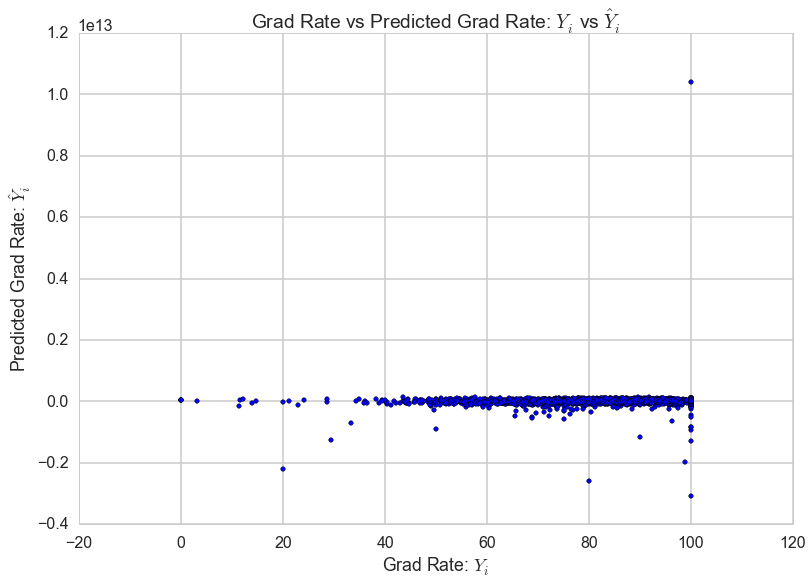

In [218]:
plt.scatter(ytest, yp)
plt.xlabel("Grad Rate: $Y_i$")
plt.ylabel("Predicted Grad Rate: $\hat{Y}_i$")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")

##### Lasso Regression

In [219]:
lasso = linear_model.Lasso()

In [220]:
lasso.fit(Xtrain, ytrain)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [221]:
print lasso.coef_
print lasso.intercept_

[-0.         -0.         -0.         -0.23207026  0.         -0.          0.
 -0.          0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.         -0.
  0.          0.         -0.         -0.         -0.86458644  0.67996076
 -0.         -0.         -0.1656676  -2.63796268  0.          0.         -0.
  0.7963431   0.          0.45929885  0.          0.         -0.
 -1.97416884  1.51542098  0.69191355  0.          0.          0.          0.
 -0.         -0.         -0.         -0.          0.78471809  0.          0.
  0.         -0.         -0.          0.         -0.          0.          0.
  0.          0.         -0.          0.         -0.          0.          0.
  0.          0.          0.          0.         -0.          0.          0.
 -0.          0.         -0.          0.          0.          0.         -0.
 -0.         -0.          0.         -0.          0.         -0.          0.
  0.          0

In [222]:
pd.DataFrame(zip(dftouse0607[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:10]

,features,estimatedCoefficients
41,r_stud_re_W,1.515421
34,r_stud_912,0.796343
51,r_stud_reg_12_W_M,0.784718
42,r_stud_re_Total,0.691914
26,tlocrev_percent,0.679961
36,r_stud_re_F,0.459299
0,num_students,-0.000000
120,r_frev_ia,0.000000
113,r_frev_dis,0.000000
114,r_frev_cna,0.000000


In [223]:
pd.DataFrame(zip(dftouse0607[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:10]

,features,estimatedCoefficients
30,r_lunch_free,-2.637963
40,r_stud_re_B,-1.974169
25,tfedrev_percent,-0.864586
3,num_pub_schools,-0.232070
118,r_frev_ao,-0.194367
29,r_IEP,-0.165668
112,r_frev_title1,-0.000000
113,r_frev_dis,0.000000
114,r_frev_cna,0.000000
115,r_frev_ems,0.000000


In [224]:
from sklearn import cross_validation
cross_validation.cross_val_score(lasso, Xtrain, ytrain, scoring='r2')

array([ 0.31778689,  0.29019044,  0.30950528])

In [225]:
yp = lasso.predict(Xtest)
mean_squared_error(yp, ytest)

138.98504983649372

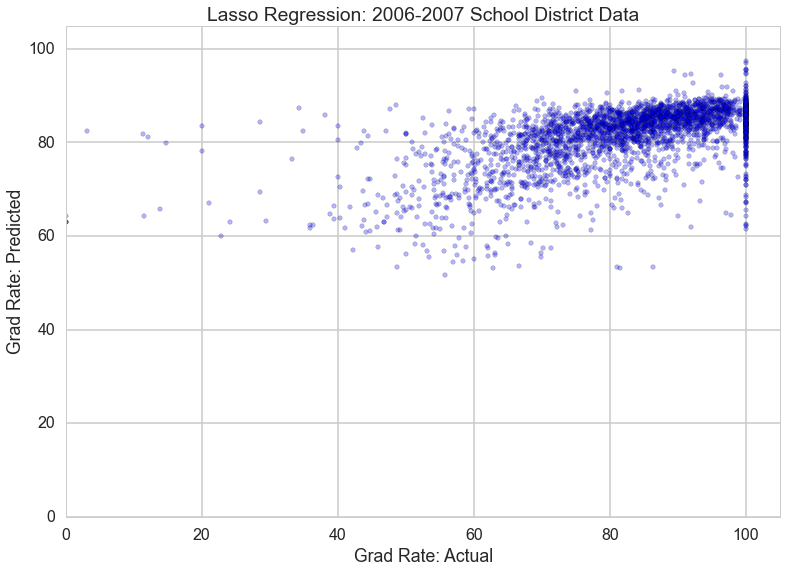

In [226]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Lasso Regression: 2006-2007 School District Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

##### Elastic Net

In [227]:
elasticnet = linear_model.ElasticNet()
elasticnet.fit(Xtrain, ytrain)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [228]:
print elasticnet.coef_
print elasticnet.intercept_

[-0.         -0.26852297 -0.         -0.31862813  0.02282437 -0.
  0.04705953 -0.          0.         -0.20622595 -0.4631015  -0.         -0.
 -0.         -0.         -0.         -0.          0.          0.         -0.
 -0.          0.08351299 -0.         -0.         -0.         -0.90096819
  0.71217165 -0.10663566 -0.06145072 -0.48733653 -1.72907564 -0.          0.
 -0.          0.7123458   0.          0.58992486  0.          0.19491633
 -0.15853733 -1.48617717  1.32010486  0.64142451  0.00466375  0.16279223
  0.          0.20278192 -0.         -0.         -0.         -0.24271298
  0.78638653  0.5397434   0.          0.          0.          0.          0.
 -0.          0.          0.33246841  0.          0.         -0.          0.
 -0.          0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.38264608 -0.07633559
  0.          0.18284516  0.0525517  -0.         -0.         -0.          0.
 -0.          0.12951273 -0.   

In [229]:
pd.DataFrame(zip(dftouse0607[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:20]

,features,estimatedCoefficients
41,r_stud_re_W,1.320105
51,r_stud_reg_12_W_M,0.786387
34,r_stud_912,0.712346
26,tlocrev_percent,0.712172
42,r_stud_re_Total,0.641425
36,r_stud_re_F,0.589925
52,r_stud_reg_12_W_F,0.539743
76,r_lrev_pt,0.382646
60,r_st_ST,0.332468
46,r_stud_reg_12_AAP_F,0.202782


In [230]:

pd.DataFrame(zip(dftouse0607[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:20]

,features,estimatedCoefficients
30,r_lunch_free,-1.729076
40,r_stud_re_B,-1.486177
25,tfedrev_percent,-0.900968
29,r_IEP,-0.487337
10,tfedrev_pp,-0.463101
118,r_frev_ao,-0.418732
3,num_pub_schools,-0.318628
1,num_schools,-0.268523
50,r_stud_reg_12_B_F,-0.242713
9,tsrev_pp,-0.206226


In [231]:
cross_validation.cross_val_score(elasticnet, Xtrain, ytrain, scoring='r2')

array([ 0.34239474,  0.29925796,  0.32886435])

In [232]:
yp = elasticnet.predict(Xtest)
mean_squared_error(yp, ytest)

137.38415277697291

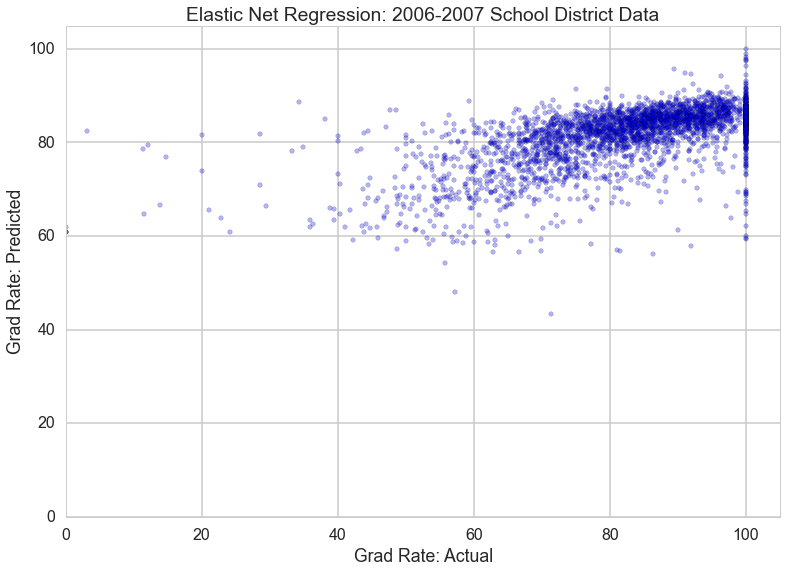

In [233]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Elastic Net Regression: 2006-2007 School District Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

### Creating a best model

Again, creating a best model based off of features that we learned from elastic net.

In [251]:
lcols=['r_stud_re_W','r_stud_912','r_stud_reg_12_W_M','tlocrev_percent','r_stud_re_Total','r_lunch_free','r_stud_re_B','tfedrev_percent','tfedrev_pp','r_frev_ao','r_stud_re_F','r_stud_reg_12_W_F','r_srev_gt','num_pub_schools']

In [252]:
Xmatrix=dftouse0607[lcols].values
Yresp=dftouse0607['afgr'].values

In [253]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [254]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [255]:
print lm.intercept_
print lm.coef_

81.3158789325
[ 0.96410979  1.3447487   1.26397522  1.58634393  0.94112961 -2.85007117
 -2.64246271 -0.47835623 -0.78057359 -0.96083192  1.4605643  -0.072313
 -0.55695665 -0.89861253]


In [256]:
pd.DataFrame(zip(dftouse0607[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,r_stud_re_W,0.964110
1,r_stud_912,1.344749
2,r_stud_reg_12_W_M,1.263975
3,tlocrev_percent,1.586344
4,r_stud_re_Total,0.941130
5,r_lunch_free,-2.850071
6,r_stud_re_B,-2.642463
7,tfedrev_percent,-0.478356
8,tfedrev_pp,-0.780574
9,r_frev_ao,-0.960832


In [257]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.3804736 ,  0.30699547,  0.31459218])

In [258]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

134.02518900051794

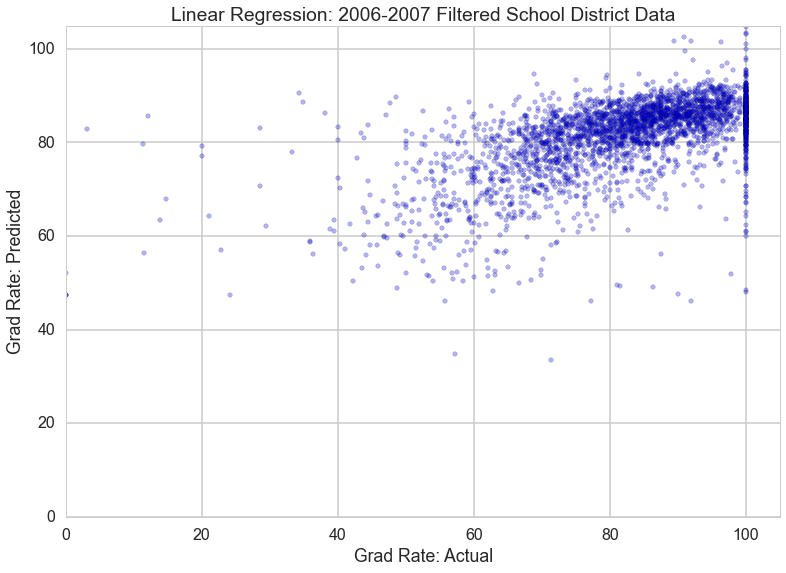

In [259]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: 2006-2007 Filtered School District Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

### Predicting 2009-2010 graduation rate from 2006-2007 data.

We have our model of 2006-2007 graduation, and we try plugging in 2009-2010 data.  This is the scenario of having school district data available, but no graduation rates.

In [260]:
ActualX=dftouse[lcols].values
Actualy=dftouse['afgr'].values

In [261]:
yp = lm.predict(ActualX)
mean_squared_error(yp, Actualy)

116.98696259496226

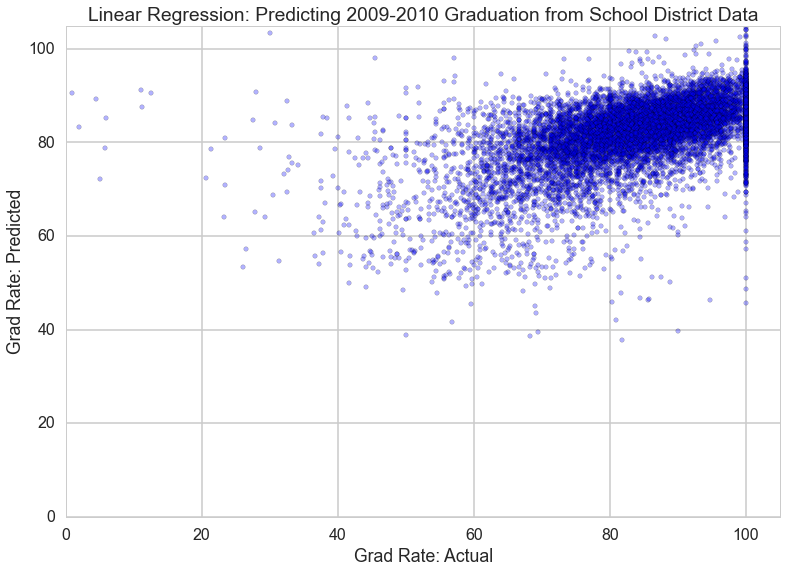

In [264]:
plt.scatter(Actualy, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: Predicting 2009-2010 Graduation from School District Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

The mean squared error is comparable to our earlier models.  Absent any available graduation rate data for 5 years, one could fill in the missing data using a predictive model until such graduation rate data becomes publically available.